In [38]:
import matplotlib.pyplot as plt
import pandas as p
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import linregress
from scipy.spatial import distance
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import scipy
import sys
import os
from matplotlib.backends.backend_pdf import PdfPages
# from sklearn.decomposition import PCA
from ast import literal_eval
from Bio import SeqIO
from itertools import combinations

%load_ext autoreload
%autoreload 2 

# atish_assay_path = '../code/fitness_assay_grantedits.py'
# sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
# import fitness_assay_grantedits as atish

tools_path = 'code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

import Levenshtein

sns.set_color_codes()
sns.set_style('white')
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
rebarcoding_source_mutants = {
'IRA1_MIS':'CGCTAAAGACATAATGTGGTTTGTTG_CTTCCAACAAAAAATCATTTTTATAC', # BCID 43361 from venkataram 2016
'IRA1_NON':'CGCTAAAGACATAATGTGGTTTGTTG_AGAGTAATCTGCAAGATTCTTTTTCT', # BCID 21967 from venkataram 2016
'CYR1':    'CGCTAAAGACATAATGTGGTTTGTTG_CTCGAAACAGGAAAAGCACTTATCGA', # BCID 43692 from venkataram 2016
'TOR1':    'CGCTAAAGACATAATGTGGTTTGTTG_TAGACAAAATGCAATTGTATTGTCAG' , # BCID 21543 from venkataram 2016
'GPB2':    'CGCTAAAGACATAATGTGGTTTGTTG_TCATGAACGGATAAGCTGGTTGGTTG' , # BCID 7774 from venkataram 2016
}



new_lowcomplexity_dict = {
#     'EVO1D_IRAs':[
# #         'CATAAAAAGACTAATCTTATTAATGC', # 74D-2 (Ira1 mis)
#                   'AATGCAATAATGAAATGATTTGAGGA',
# #                  'TGTACAAATCTTAAGAAGATTACAAG',  #YP 12 (IRA1 non)
#                   'GAAATAAACCACAACGACATTCTAAT',
# #                   'CCTACAAATACTAAGGCTATTCCTAT', #YP 10 (IRA1 non)
#                  ]
    
    'EVO1D_IRA1_MIS':['CATAAAAAGACTAATCTTATTAATGC'],
    
    'EVO1D_IRA1_NON':['CCTACAAATACTAAGGCTATTCCTAT','TGTACAAATCTTAAGAAGATTACAAG',
                     'AATGCAATAATGAAATGATTTGAGGA','GAAATAAACCACAACGACATTCTAAT'],
    
#     'EVO1D_TCG':['CCGCCAATCCCGAACCCCGTTTCGCC','GACAGAAAAGCCAAATGGATTTACCG',
#  'ATCAGAAGTTCGAATCAAATTACGAA','CCAACAAAAGGAAACGTATTTATTGA',
#  'TTAAAAATACAAAAAAAGATTTAAGG','AGAACAAAAACTAAACTCATTCATGG',
#  'ACTTAAAAAGCAAACATGATTATTCA','GTATTAAAATTAAAAATAATTGCACA',
#  'CTAGAAATCTCAAAAACTTTTGGCTG','CAGAAAAGCCATAACGCTATTTGAAA'],
    
    'EVO2D_IRA1_NON':['CCAACAAAACACAAATCTGTTGTGTA'],

    'EVO2D_IRA1_MIS':['TGATCAATCTACAAAAATATTTAATG','CATTGAATCACAAAATAGGTTAGATG'],

    'EVO3D_IRA1_NON':['ATCACAATAACTAAACTGATTCTTCA'],

    'EVO3D_IRA1_MIS':['TATCGAAACCCAAAGAGATTTAATCG'],

    'CYR1':['AGAACAAAAACTAAACTCATTCATGG','GACAGAAAAGCCAAATGGATTTACCG',
           'CTAGAAATCTCAAAAACTTTTGGCTG','ACTTAAAAAGCAAACATGATTATTCA',
            'CAGAAAAGCCATAACGCTATTTGAAA'],
    
    'GPB2':['CCGCCAATCCCGAACCCCGTTTCGCC','GTATTAAAATTAAAAATAATTGCACA',
            'CCAACAAAAGGAAACGTATTTATTGA'],
    
    'TOR1':['ATCAGAAGTTCGAATCAAATTACGAA','TTAAAAATACAAAAAAAGATTTAAGG'],
    

}

new_lowcomplexity_bc_to_entry_dict = {}

for key,items in new_lowcomplexity_dict.items():
    for bc in items:
        new_lowcomplexity_bc_to_entry_dict[bc] = key

new_lowcomplexity_barcodes = [item for key,items in new_lowcomplexity_dict.items() for item in items ]

new_lowcomplexity_by_anc = {}
new_lowcomplexity_by_anc['IRA1_MIS'] = []
for key in ['EVO1D_IRA1_MIS','EVO2D_IRA1_MIS','EVO3D_IRA1_MIS']:
    for bc in new_lowcomplexity_dict[key]:
        new_lowcomplexity_by_anc['IRA1_MIS'].append(bc)
    
new_lowcomplexity_by_anc['IRA1_NON'] = []
for key in ['EVO1D_IRA1_NON','EVO2D_IRA1_NON','EVO3D_IRA1_NON']:
    print(key,new_lowcomplexity_dict[key])
    for bc in new_lowcomplexity_dict[key]:
        new_lowcomplexity_by_anc['IRA1_NON'].append(bc)
        
        
new_lowcomplexity_by_anc['CYR1'] = new_lowcomplexity_dict['CYR1']
new_lowcomplexity_by_anc['GPB2'] = new_lowcomplexity_dict['GPB2']
new_lowcomplexity_by_anc['TOR1'] = new_lowcomplexity_dict['TOR1']

EVO1D_IRA1_NON ['CCTACAAATACTAAGGCTATTCCTAT', 'TGTACAAATCTTAAGAAGATTACAAG', 'AATGCAATAATGAAATGATTTGAGGA', 'GAAATAAACCACAACGACATTCTAAT']
EVO2D_IRA1_NON ['CCAACAAAACACAAATCTGTTGTGTA']
EVO3D_IRA1_NON ['ATCACAATAACTAAACTGATTCTTCA']


In [3]:
conditions = ['Fit1D-2%','Fit1D-5%',
              'Fit2D-2%','Fit2D-5%',
              'Fit3D-2%','Fit3D-5%',
              'Fit5D-2%','Fit5D-5%']

# replicates = [1,2,3]
replicates = {'Fit1D-2%':[1,2],
              'Fit1D-5%':[1,2],
              'Fit2D-2%':[1,2],
              'Fit2D-5%':[1,2],
              'Fit3D-2%':[1,2,3],
              'Fit3D-5%':[1,2,3],
              'Fit5D-2%':[1,2,3],
              'Fit5D-5%':[1,2,3]}

timepoints = {'Fit1D-2%':7,
              'Fit1D-5%':7,
              'Fit2D-2%':7,
              'Fit2D-5%':7,
              'Fit3D-2%':3,
              'Fit3D-5%':3,
              'Fit5D-2%':3,
              'Fit5D-5%':3}

In [8]:
ploidy_calls = p.read_csv('BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')
merged_fitness = p.read_csv('2%5%_FitnessMeasurement/EvolvingFront_2%5%FitnessMeasurementData.csv')
time_fitness = p.read_csv('2%5%_FitnessMeasurement/EvolvingFront_2%5%FitnessMeasurementData_fitnessByTime.csv')

In [44]:
new_conditions = {'Fit1D_both2%5%':['Fit1D-2%','Fit1D-5%'],
                 'Fit2D_both2%5%':['Fit2D-2%','Fit2D-5%'],
                 'Fit3D_both2%5%':['Fit3D-2%','Fit3D-5%'],
                 'Fit5D_both2%5%':['Fit5D-2%','Fit5D-5%']}


for new_condition,old_conditions in new_conditions.items():
    
    new_f = np.nansum([merged_fitness[f'{condition}_fitness'].values/merged_fitness[f'{condition}_error'].values for condition in old_conditions],axis=0) \
    /np.nansum([1.0/merged_fitness[f'{condition}_error'].values for condition in old_conditions],axis=0)
    
    merged_fitness[f'{new_condition}_fitness'] = new_f
    
    new_error = np.nansum([1.0/merged_fitness[f'{condition}_error'].values for condition in old_conditions],axis=0)**(-1)
    
    merged_fitness[f'{new_condition}_error'] = new_error
    
    new_f = np.nansum([merged_fitness[f'{condition}_fitness_Li2019Neutrals'].values/merged_fitness[f'{condition}_error_Li2019Neutrals'].values for condition in old_conditions],axis=0) \
    /np.nansum([1.0/merged_fitness[f'{condition}_error_Li2019Neutrals'].values for condition in old_conditions],axis=0)
    
    merged_fitness[f'{new_condition}_fitness_Li2019Neutrals'] = new_f
    
    new_error = np.nansum([1.0/merged_fitness[f'{condition}_error_Li2019Neutrals'].values for condition in old_conditions],axis=0)**(-1)
    
    merged_fitness[f'{new_condition}_error_Li2019Neutrals'] = new_error




    

In [11]:
full_cloneID_list = []
full_ploidy_list = []
evo_cond_list = []
anc_list = []

for barcode,cloneID,source,ploidy,evo_cond,anc in zip(merged_fitness['barcode'].values,
                                         merged_fitness['cloneID'].values,
                                         merged_fitness['source_publication'].values,
                                         merged_fitness['ploidy'].values,
                                         merged_fitness['evolution_condition'].values,
                                         merged_fitness['ancestor'].values):
    if source == 'This_study':
        
        
        this_bc = ploidy_calls[ploidy_calls['barcode']==barcode]
        
        if len(this_bc) == 0:
            this_id = np.nan
            full_cloneID_list.append(np.nan)
            full_ploidy_list.append('?')
        elif len(this_bc) > 1:
            print('hmm... more that one found')
            full_cloneID_list.append(this_bc['destination_well'].values[0])
            full_ploidy_list.append(this_bc['ploidy'].values[0])
            this_id = this_bc['destination_well'].values[0]
        else:
            full_cloneID_list.append(this_bc['destination_well'].values[0])
            full_ploidy_list.append(this_bc['ploidy'].values[0])
            this_id = this_bc['destination_well'].values[0]
#         print('this_condition')
        
        bc_low_complexity = barcode.split('_')[0]
        
        entry = new_lowcomplexity_bc_to_entry_dict[bc_low_complexity]
        
        if 'IRA1_NON' in entry:
            anc_list.append('IRA1_NON')
        elif 'IRA1_MIS' in entry:
            anc_list.append('IRA1_MIS')
        elif entry in ['TOR1','CYR1','GPB2']:
            anc_list.append(entry)
            entry = this_id
            
        
        if not p.isnull(entry):
            if 'EVO1D' in entry:
                evo_cond_list.append('Evo1D')
            elif 'EVO2D' in entry:
                evo_cond_list.append('Evo2D')
            elif 'EVO3D' in entry:
                evo_cond_list.append('Evo3D')
            else:
                evo_cond_list.append('unknown')
        else:
            evo_cond_list.append('unknown')
            
        
        
        

    
    else:

        full_cloneID_list.append(cloneID)
        full_ploidy_list.append(ploidy)
        evo_cond_list.append(evo_cond)
        anc_list.append(anc)
        
merged_fitness['cloneID_new'] = full_cloneID_list
merged_fitness['ploidy_new'] = full_ploidy_list
merged_fitness['evolution_condition'] = evo_cond_list
merged_fitness['ancestor'] = anc_list

hmm... more that one found
hmm... more that one found
hmm... more that one found
hmm... more that one found
hmm... more that one found
hmm... more that one found
hmm... more that one found


In [37]:
##### FILTER OUT BARCODES THAT ARE SEQUENCING ERRORS OF ANOTHER "REAL" BARCODE

sequencing_error_id = {}
sequencing_error_count = {}

removal_list = []

timepoint_to_use = 'Fit1D-5%-T0'

sorted_ix = np.argsort(merged_fitness[timepoint_to_use])[::-1]


barcodes_sorted_by_tp = merged_fitness['barcode'].values[sorted_ix]

for bc1,bc2 in combinations(barcodes_sorted_by_tp,2):
    this_dist = Levenshtein.distance(str(bc1),str(bc2))
    if this_dist < 4:

        count1 = merged_fitness[merged_fitness['barcode']==bc1][timepoint_to_use].values[0]
        count2 = merged_fitness[merged_fitness['barcode']==bc2][timepoint_to_use].values[0]
        
        if count1 > count2:
            big_bc = f'{bc1}_{count1}'
#             big_count = count1
            small_bc = f'{bc2}_{count2}'
#             small_count = count2
        else:
            small_bc = f'{bc1}_{count1}'
#             small_count = count1
            big_bc = f'{bc2}_{count2}'
#             big_count = count2

        if big_bc in sequencing_error_id.keys():
            if small_bc in sequencing_error_id.keys():
                sequencing_error_id[big_bc] = set.union(sequencing_error_id[big_bc],sequencing_error_id[small_bc])
                del sequencing_error_id[small_bc]
            else:
                sequencing_error_id[big_bc].add(small_bc)
                
#                 for bc,neighborhood in sequencing_error_id.items():
#                     if small_bc in neighborhood:
#                         if big_bc.split('_')[-1] >= bc.split('_')[1]:
#                             sequencing_error_id[big_bc] = set.union(sequencing_error_id[big_bc],sequencing_error_id[bc])
        else:
            for bc,neighborhood in sequencing_error_id.items():
                if big_bc in neighborhood:
                    break
            else:
                sequencing_error_id[big_bc] = set([small_bc])



In [39]:
sequencing_error_id = {('_'.join(k.split('_')[:2])):['_'.join(i.split('_')[:2]) for i in list(v)] for (k,v) in sequencing_error_id.items()}

sequencing_error_bcs = tools.flatten(sequencing_error_id.values())

In [40]:
sequencing_error_bcs

['CCGCCAATCCCGAACCCCGTTTCGCC_ACTATAACGTGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGCGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_GCTCTAACGTGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAGCTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATATTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTAAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTAGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTTAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTATAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAATGTGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACATGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACCCTAACGTGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTATGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGA',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTTTAACGTGTAACTAATTTTGAGT',
 'CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTGACTAATTTTGAGT',
 'AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGGAAGGGTATTTTAAG',
 'AGAACAAAAACT

In [70]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [72]:
merged_fitness[~merged_fitness['barcode'].isin(sequencing_error_bcs)]

merged_fitness['barcode_fasta'] = [f'{high}{low}' for high,low in 
                                   zip(merged_fitness['barcode_highcomplexity'].values,merged_fitness['barcode_lowcomplexity'].values)]

# merged_fitness = merged_fitness.reset_index()
merged_fitness['BCID'] = merged_fitness.index

cols_for_bc_list = ['BCID','barcode_fasta','barcode','barcode_lowcomplexity','barcode_highcomplexity','source_publication',
                    'cloneID','cloneID_new','evolution_condition','ancestor','class','ploidy',
                    'ploidy_new','gene','type','additional_muts',
                    '1D_Fitness_Li2019','1D_Error_Li2019',
                    '2D_Fitness_Li2019','2D_Error_Li2019',
                    '3D_Fitness_Li2019','3D_Error_Li2019',
                    '5D_Fitness_Li2019','5D_Error_Li2019',
                    'FerPerHour_Li2019','ResPerHour_Li2019','StaPerHour_Li2019']

merged_fitness[cols_for_bc_list].to_csv('barcodes_curated_30April2022.csv',index=False)





filtered_bcs = []

for BCID,sequence in zip(merged_fitness['BCID'].values,merged_fitness['barcode_fasta'].values):
#     seq_low,seq_high = sequence.split('_')
    
    record = SeqRecord(Seq(sequence),id=f'{BCID}',name='',description='')
    filtered_bcs.append(record)
    
filtered_bcs.append(SeqRecord(Seq('CGCTAAAGACATAATGTGGTTTGTTGGAATTAAGTTGGAACAGTGTTGACAGGTGCAC'),id='9999999',name='',description=''))

# len(filtered_bcs)
# SeqIO.write(filtered_bcs, "BClist_curatedNEW+known.fa", "fasta")
SeqIO.write(filtered_bcs,'barcodes_curated_30April2022.fasta','fasta')

5028

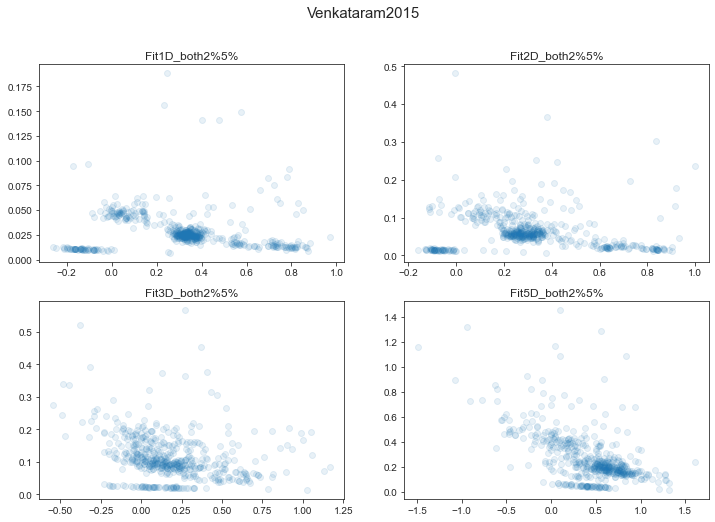

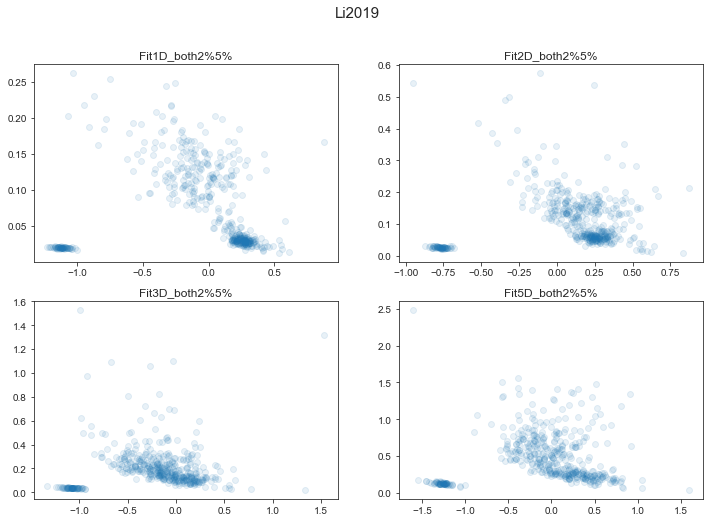

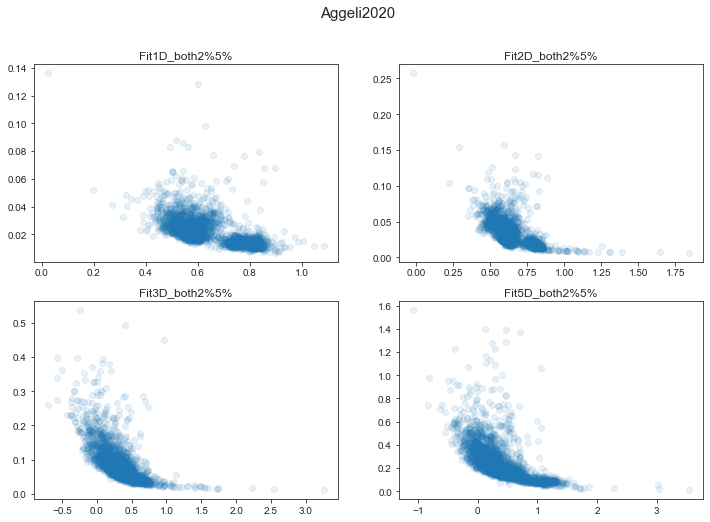

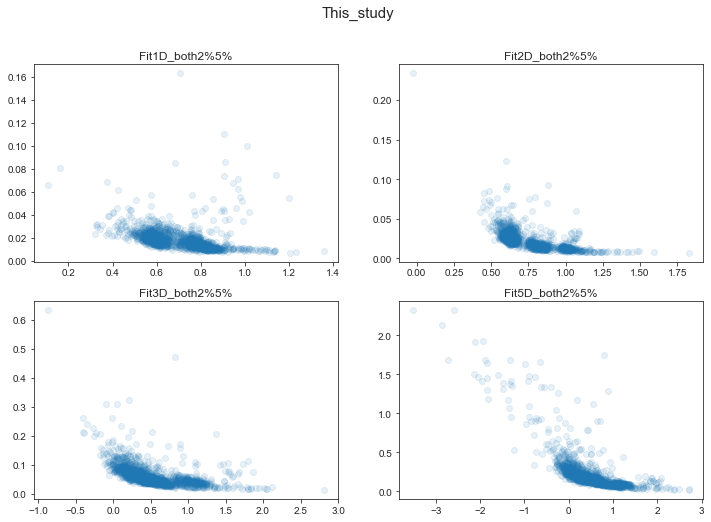

In [60]:
cols = ['Fit1D_both2%5%','Fit2D_both2%5%','Fit3D_both2%5%','Fit5D_both2%5%']


for pub_set in ['Venkataram2015','Li2019','Aggeli2020','This_study']:
    
#     plt.title(pub_set)
    plt.figure(figsize=(12,8))
    this_set = merged_fitness[merged_fitness['source_publication']==pub_set]
    plt.suptitle(pub_set,size=15)
    for c,col in enumerate(cols):
        plt.subplot(2,2,c+1)
        plt.title(col)
        plt.scatter(this_set[f'{col}_fitness'],
                    this_set[f'{col}_error'],
                    alpha=0.1)

In [55]:
merged_fitness[merged_fitness['Fit3D_both2%5%_error'] > 1.2][['Fit1D-5%-T0','barcode','Fit3D_both2%5%_fitness','source_publication']].values

array([[20, 'GTAATAAGAAGTAAGATGATTCTATT_TTCTTAAGTGTAAAGATATTTCCCTT',
        -0.9970291151740628, 'Li2019'],
       [11, 'ATCTTAAATTTTAATTACATTTACAT_TCTTCAAAGGGCAATCTGGTTGAGCA',
        1.5321883791146471, 'Li2019']], dtype=object)

In [51]:
merged_fitness[merged_fitness['barcode']=='ATCTTAAATTTTAATTACATTTACAT_TCTTCAAAGGGCAATCTGGTTGAGCA']

,Fit1D-2%-R1_error,Fit1D-2%-R1_fitness,Fit1D-2%-R2_error,Fit1D-2%-R2_fitness,Fit1D-5%-R1_error,Fit1D-5%-R1_fitness,Fit1D-5%-R2_error,Fit1D-5%-R2_fitness,Fit2D-2%-R1_error,Fit2D-2%-R1_fitness,...,Fit2D_both2%5%_fitness_Li2019Neutrals,Fit2D_both2%5%_error_Li2019Neutrals,Fit3D_both2%5%_fitness,Fit3D_both2%5%_error,Fit3D_both2%5%_fitness_Li2019Neutrals,Fit3D_both2%5%_error_Li2019Neutrals,Fit5D_both2%5%_fitness,Fit5D_both2%5%_error,Fit5D_both2%5%_fitness_Li2019Neutrals,Fit5D_both2%5%_error_Li2019Neutrals
4936,0.58183,0.218526,1.176652,-0.25429,0.725009,0.328451,0.998923,-0.384358,0.993142,1.054875,...,1.143716,0.350217,1.532188,1.316797,2.388872,1.316797,0.516035,1.478003,1.610036,1.478003


In [54]:
for barcode in merged_fitness['barcode_highcomplexity']:
    if Levenshtein.distance(barcode,'TCTTCAAAGGGCAATCTGGTTGAGCA') < 10:
        print(barcode,Levenshtein.distance(barcode,'TCTTCAAAGGGCAATCTGGTTGAGCA') )

TGTACAAGCGACAATCTTATTGACCC 9
TCCACAAAGGGTAAACCGTTTCTGCG 9
GCCCAAATGTCTAATCGGGTTAGAGC 9
TTTTAAAGGAATAATCTGGTTGTAAC 8
TTTCAAAGTGGTAATCTGATTTGTCA 7
CTGCAAACGGGTAATTTGGTTGCCGT 9
CCCTAAAGTGGCAAGGGGGTTGGGCA 8
TCTTCAAATGAAAACCTAATTGCGCC 8
ATTTCAATGGGGAATCTAGTTGTCGC 8
ACTGCAAACGTAAAGCAGGTTCTGCA 9
TTCTAAATATGGAATGGGGTTGAGCG 9
TTTAAAAACGCAAACTGGTTTTCAGA 9
TCCTCAACGAACAACTGGCTTGTCAA 9
TCCCCAAAAGCAAACGGGATTGAGGT 9
GCTGGAAAGGTCAACCGGGTTGGAAG 9
GCTTGAACTCGCAATCAAGTTGACAT 9
TCTAGAAAGGTCAACAAGCTTGCGTA 9
CTTACAATAGGTAATATGGTTCGGGC 9
TATTCAACCTGCAATCTTGTTCTGGA 8
CATCAAAAGGATAACCGGGTTGTGTA 9
GCCTTAAGTGCTAATCTCGTTGAGAC 9
TGCTAAAGAGCGAAGGGGGTTGAGGA 9
TTAGAAATGGCTAATCTAGTTATCAG 9
TTTCTAATGGAGAAACTGGTTGGGGG 9
TCTTGAATGAGCAAATTTCTTGATGC 9
CTTCTAAACGTCAATCGGTTTTTCAA 9
CCTAGAAGAGGGAAGGTGGTTGCGTA 9
TCTCAAAGGTCTAATACTCTTATAGA 9
TCTTGAAAATGAAATCTTCTTGGAAT 9
GATTCAAGTAGCAATCTTTTTGAAAA 9
ATCTAAAGTGGCAAATCAGTTTGATA 9
ACACAAAAAGTTAAGGTGGTTGAGCA 9
CTAGCAATCGGCAATTCTGTTGACAG 9
TTTCAAATCGGGAAATCTTTTAAGAT 9
TTTCAAAGGTTTAA

In [ ]:
merged_fitness['barcode_highcomplexity']